In [1]:
import mysql.connector
import pandas as pd
import matplotlib.pyplot as plt
%run "txt_extractor.ipynb"
import config 
import seaborn as sns
import numpy as np
import statsmodels.api as sm 
from statsmodels.formula.api import ols 

In [2]:
# this connects to the database

mydb = mysql.connector.connect(
  host="localhost",
  user="root",
  password=config.password,
  database="abstracts"
)

In [3]:
def date_intervalls(row):
    if row["Publish_Date"] <= "1985-12-31" and row["Publish_Date"] >= "1980-01-01":
        return "1980-1985"
    elif row["Publish_Date"] <= "1990-01-01" and row["Publish_Date"] >= "1985-01-01":
        return "1985-1990"
    elif row["Publish_Date"] <= "1995-01-01" and row["Publish_Date"] >= "1990-01-01":
        return "1990-1995"
    elif row["Publish_Date"] <= "2000-01-01" and row["Publish_Date"] >= "1995-01-01":
        return "1995-2000"
    elif row["Publish_Date"] <= "2005-01-01" and row["Publish_Date"] >= "2000-01-01":
        return "2000-2005"
    elif row["Publish_Date"] <= "2010-01-01" and row["Publish_Date"] >= "2005-01-01":
        return "2005-2010"
    elif row["Publish_Date"] <= "2015-01-01" and row["Publish_Date"] >= "2010-01-01":
        return "2010-2015"
    elif row["Publish_Date"] <= "2020-01-01" and row["Publish_Date"] >= "2015-01-01":
        return "2015-2020"
    else:
        return "out of range"
    

In [4]:
### this code is for extracting all data necessary for speechgraphs analysis from the database ###

mycursor = mydb.cursor()
mycursor.execute('SELECT a.Content, v.positivity, m.Publish_Date, m.Science, m.AbstractID\
                  FROM meta m\
                  JOIN valence v ON m.AbstractID = v.AbstractID\
                  JOIN abstract a ON m.AbstractID = a.AbstractID\
                  WHERE a.Rejected = 0')

df = pd.DataFrame(mycursor.fetchall(), columns=['Content', 'Positivity', 'Publish_Date', 'Science', "AbstractID"])
df = df.astype({'Science': 'category'})
df = df.astype({"Publish_Date": 'str'})
df['Date_Interval'] = df.apply(date_intervalls, axis=1)
df = df[df.Date_Interval != "out of range"]

In [21]:
def plot_pos_values(df, subplots = False):
    # this function plot the mean positvity values for each science field and time interval
    #  
    plot_df = df.groupby(["Science", "Date_Interval"])["Positivity"].mean().reset_index()
    if subplots:
        fig, axs = plt.subplots(4, 2, figsize=(15, 20))
        fig.suptitle("Mean Vader positivity score per publishing interval", fontsize=24)
        
        science_fields = ["bio", "che", "phy", "mat", "inf", "hum", "psy"]
        titles = ["Biology", "Chemistry", "Physics", "Mathematics", "Computer Science", "Humanities", "Psychology"]

        for i, (field, title) in enumerate(zip(science_fields, titles)):
            col, row = divmod(i, 4)
            ax = axs[row, col]
            sns.lineplot(data=plot_df[plot_df["Science"] == field], x="Date_Interval", y="Positivity", ax=ax, marker='o')
            ax.set(xlabel = "Publication date", ylabel = "Mean Vader positivity score")
            ax.set_ylim(0,0.04)
            ax.set_title(title)
            plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
        
        sns.despine()
        plt.tight_layout(h_pad = 2, pad = 2, w_pad = 1.5)
        # Hide the last subplot (bottom-right) if there are only 7 plots
        axs[3, 1].axis('off')
    else:
        plt.figure(figsize=(10, 5))
        plt.title(f"Mean Vader positivity score per publishing interval", fontsize=24)
        plt.xlabel("Publication date")
        plt.ylabel("Average positive words")
        sns.lineplot(data=plot_df, x="Date_Interval", y="Positivity", marker='o',style="Science", hue= "Science" , palette="Greys", markers=True)
        plt.xticks(rotation=45)
        sns.despine()
        plt.show()



C:\Users\buchries\AppData\Local\Temp\ipykernel_4576\3887533039.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  plot_df = df.groupby(["Science", "Date_Interval"])["Positivity"].mean().reset_index()


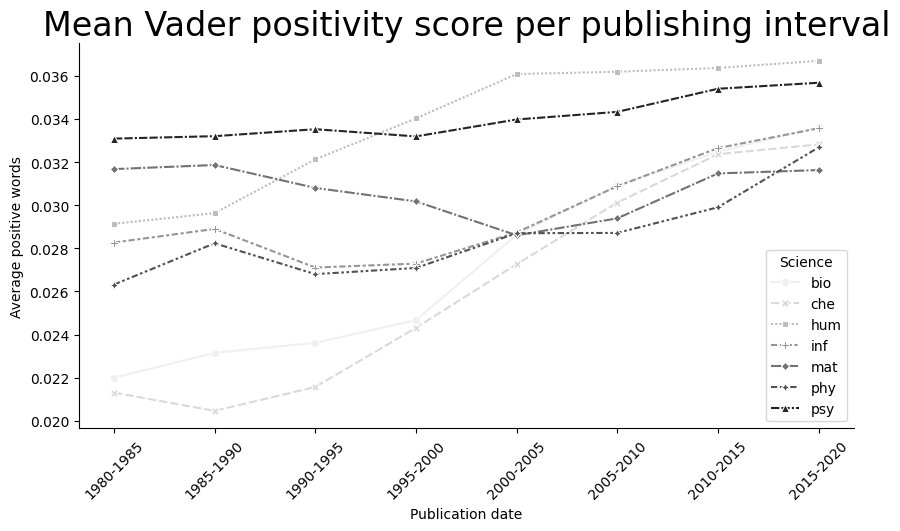

In [22]:
plot_pos_values(df, subplots=False)

In [65]:
# this function calculatres a two way anova with the positiviy as dependent variable and the science field and the date interval as predictor variables
# the anova is bootstrapped reps times with a sample of n
def anova(df, reps, n):
    result_table = pd.DataFrame(columns=["effect", "df", "sum_sq", "mean_sq", "F", "PR(>F)"])
    result_table["effect"] = ["Science_lower", "Date_Interval_lower", "Science:Date_Interval_lower", "Residuals_lower", "Science_upper", "Date_Interval_upper", "Science:Date_upper", "Residuals_upper"]
    results = []
    for i in range(reps):
        sample = df.sample(n)
        model = ols('Positivity ~ Science + Date_Interval +\
        Science:Date_Interval', 
                data=sample).fit() 
        results.append(sm.stats.anova_lm(model, type=2))
    Science_df = pd.DataFrame(columns=["df", "sum_sq", "mean_sq", "F", "PR(>F)"])
    Date_df = pd.DataFrame(columns=["df", "sum_sq", "mean_sq", "F", "PR(>F)"])
    ScienceX_date_df = pd.DataFrame(columns=["df", "sum_sq", "mean_sq", "F", "PR(>F)"])
    Residuals_df = pd.DataFrame(columns=["df", "sum_sq", "mean_sq", "F", "PR(>F)"])

    for y, i in enumerate(results):
        Science_df.loc[y] = i.iloc[0]
        Date_df.loc[y] = i.iloc[1]
        ScienceX_date_df.loc[y] = i.iloc[2]
        Residuals_df.loc[y] = i.iloc[3]

    for y, i in enumerate(Science_df.columns):
        result_table.iloc[0, y+1] = Science_df[i].quantile(0.025)
        result_table.iloc[1, y+1] = Date_df[i].quantile(0.025)
        result_table.iloc[2, y+1] = ScienceX_date_df[i].quantile(0.025)
        result_table.iloc[3, y+1] = Residuals_df[i].quantile(0.025)

        result_table.iloc[4, y+1] = Science_df[i].quantile(0.975)
        result_table.iloc[5, y+1] = Date_df[i].quantile(0.975)
        result_table.iloc[6, y+1] = ScienceX_date_df[i].quantile(0.975)
        result_table.iloc[7, y+1] = Residuals_df[i].quantile(0.975)

    return result_table
    

In [66]:
result = anova(df, 1000, 5000)

In [67]:
result

,effect,df,sum_sq,mean_sq,F,PR(>F)
0,Science_lower,6.0,0.016539,0.002756,2.777442,0.0
1,Date_Interval_lower,7.0,0.010738,0.001534,1.560361,0.0
2,Science:Date_Interval_lower,42.0,0.032525,0.000774,0.777642,0.00162
3,Residuals_lower,4944.0,4.630835,0.000937,NaN,NaN
4,Science_upper,6.0,0.063597,0.0106,10.51551,0.010688
5,Date_Interval_upper,7.0,0.047495,0.006785,6.738539,0.142327
6,Science:Date_upper,42.0,0.073799,0.001757,1.770961,0.8482
7,Residuals_upper,4945.0,5.257945,0.001064,NaN,NaN


In [22]:
result[0]

,df,sum_sq,mean_sq,F,PR(>F)
Science,6.0,0.033073,0.005512,4.872887,0.000057
Date_Interval,7.0,0.021925,0.003132,2.768977,0.007146
Science:Date_Interval,42.0,0.037511,0.000893,0.789556,0.832649
Residual,4944.0,5.592558,0.001131,NaN,NaN


In [ ]:
# build confidence intervalls for all values
def confidence_intervals(result):
    

In [ ]:
results = write_split_abstracts(df, "E:\\Speechgraphs_paper\\rejected_abstracts", split="both", combine_dates = False, sample_size = 450, sampling = True, text_or_values = "values")

In [3]:
### this code is for extracting all data necessary for speechgraphs analysis from the database (Rejected Abstracts)) ###

mycursor = mydb.cursor()
mycursor.execute('SELECT a.Content, v.positivity, m.Publish_Date, m.Science, a.AbstractID\
                  FROM meta m\
                  JOIN valence v ON m.AbstractID = v.AbstractID\
                  JOIN abstract a ON m.AbstractID = a.AbstractID\
                  WHERE a.Rejected = 1 AND m.Science = "psy" OR a.Rejected = 1 AND m.Science = "phy" OR a.Rejected = 1 AND m.Science = "bio" OR a.Rejected = 1 AND m.Science = "hum"')

df = pd.DataFrame(mycursor.fetchall(), columns=['Content', 'Positivity', 'Publish_Date', 'Science', "AbstractID"])

In [7]:
write_split_abstracts(df, "E:\\Speechgraphs_paper", sample_size = 450, thirds=True, sampling = True)

100%|██████████| 509678/509678 [00:02<00:00, 230696.57it/s]


In [29]:
### extracting journals with highest pos value for different conditions ###

# all Sciences, at least 100 articles per journal
mycursor = mydb.cursor()
mycursor.execute('SELECT m.Journal, AVG(v.Positivity), COUNT(m.Journal)\
                  FROM meta m\
                  JOIN valence v ON m.AbstractID = v.AbstractID\
                  JOIN abstract a ON m.AbstractID = a.AbstractID\
                  WHERE a.Rejected = 0\
                  GROUP BY m.Journal\
                  HAVING COUNT(m.Journal) > 100\
                  ORDER BY AVG(v.Positivity) desc')

myresult = mycursor.fetchall()
plotdata = pd.DataFrame(myresult, columns=['Journal', 'Positivity', 'Count'])
plotdata.iloc[0:100].to_csv(r'E:\Journals_Study\100_most_pos_with_100_articles.csv', index = False)


# all Sciences, at least 1000 articles per journal
mycursor = mydb.cursor()
mycursor.execute('SELECT m.Journal, AVG(v.Positivity), COUNT(m.Journal)\
                  FROM meta m\
                  JOIN valence v ON m.AbstractID = v.AbstractID\
                  JOIN abstract a ON m.AbstractID = a.AbstractID\
                  WHERE a.Rejected = 0\
                  GROUP BY m.Journal\
                  HAVING COUNT(m.Journal) > 1000\
                  ORDER BY AVG(v.Positivity) desc')

myresult = mycursor.fetchall()
plotdata = pd.DataFrame(myresult, columns=['Journal', 'Positivity', 'Count'])
plotdata.iloc[0:100].to_csv(r'E:\Journals_Study\100_most_pos_with_1000_articles.csv', index = False)


# all Sciences, at least 5000 articles per journal
mycursor = mydb.cursor()
mycursor.execute('SELECT m.Journal, AVG(v.Positivity), COUNT(m.Journal)\
                  FROM meta m\
                  JOIN valence v ON m.AbstractID = v.AbstractID\
                  JOIN abstract a ON m.AbstractID = a.AbstractID\
                  WHERE a.Rejected = 0\
                  GROUP BY m.Journal\
                  HAVING COUNT(m.Journal) > 5000\
                  ORDER BY AVG(v.Positivity) desc')

myresult = mycursor.fetchall()
plotdata = pd.DataFrame(myresult, columns=['Journal', 'Positivity', 'Count'])
plotdata.iloc[0:100].to_csv(r'E:\Journals_Study\100_most_pos_with_5000_articles.csv', index = False)


# psychology, at least 100 articles per journal
mycursor = mydb.cursor()
mycursor.execute('SELECT m.Journal, AVG(v.Positivity), COUNT(m.Journal)\
                  FROM meta m\
                  JOIN valence v ON m.AbstractID = v.AbstractID\
                  JOIN abstract a ON m.AbstractID = a.AbstractID\
                  WHERE a.Rejected = 0 AND m.Science = "psy"\
                  GROUP BY m.Journal\
                  HAVING COUNT(m.Journal) > 100\
                  ORDER BY AVG(v.Positivity) desc')

myresult = mycursor.fetchall()
plotdata = pd.DataFrame(myresult, columns=['Journal', 'Positivity', 'Count'])
plotdata.iloc[0:100].to_csv(r'E:\Journals_Study\psy_100_most_pos_with_100_articles.csv', index = False)

In [4]:
print(myresult)

[('Patient education and counseling', 0.04339757881851159, 4130), ('BMC bioinformatics', 0.0419826674288328, 8308), ('Nutrients', 0.04016553077403019, 3081), ('Supportive care in cancer : official journal of the Multinational Association of Supportive Care in Cancer', 0.03977297835981219, 3079), ('Studies in health technology and informatics', 0.039296789037622536, 7443), ('Academic medicine : journal of the Association of American Medical Colleges', 0.03897986799647277, 3179), ('BMC health services research', 0.038916640668063746, 3191), ('Applied microbiology and biotechnology', 0.03861172652806395, 3070), ('IEEE transactions on medical imaging', 0.03762692098326103, 3514), ('International journal of environmental research and public health', 0.03754114155164862, 11424), ('The American journal of cardiology', 0.03721983386612051, 3489), ('Journal of clinical oncology : official journal of the American Society of Clinical Oncology', 0.03715931064918439, 3829), ('Sensors (Basel, Switze

In [53]:
# this was used for sampeling the abstracts for the eyetracking paradigm
# dont change the code below

mycursor = mydb.cursor()

mycursor.execute('SELECT r.rAbstract, m.Publish_date, v.positivity\
                  FROM raw_text r\
                  JOIN valence v ON r.AbstractID = v.AbstractID\
                  JOIN meta m ON r.AbstractID = m.AbstractID\
                  WHERE m.Science = "psy" AND m.Publish_date BETWEEN "2020-01-01" AND "2020-12-31"')

myresult = mycursor.fetchall()

df = pd.DataFrame(myresult, columns = ['Content', 'Publish_date', 'Positivity'])

df.Positivity.quantile(q = 0.25)

df.Positivity.quantile(q = 0.75)


df_low_pos = df[df.Positivity <= 0.013]
df_high_pos = df[df.Positivity > 0.051]

high_sample = df_high_pos.sample(24, random_state = 1)
low_sample = df_low_pos.sample(24, random_state = 1)

high_sample.Content.to_csv(r'E:\Abstract_MA_Study\high_sample.csv', index = False)
low_sample.Content.to_csv(r'E:\Abstract_MA_Study\low_sample.csv', index = False)